In [133]:
import logging
import pandas as pd
import os
from typing import Any
from algoshort.regime_fc import RegimeFC
from algoshort.returns import ReturnsCalculator
from algoshort.stop_loss import StopLossCalculator   # your stop-loss module
# from algoshort.position_sizing import PositionSizing  # your position sizing module
from algoshort.utils import load_config
from algoshort.optimizer import get_equity, StrategyOptimizer
import numpy as np
from algoshort.yfinance_handler import YFinanceDataHandler
from algoshort.ohlcprocessor import OHLCProcessor
from datetime import date
from algoshort.wrappers import generate_signals

handler = YFinanceDataHandler(cache_dir="./cache", enable_logging=False)
handler.download_data(['CEM.MI', 'FTSEMIB.MI'], start='2016-01-01', end=date.today(), use_cache=False)
df = handler.get_ohlc_data('CEM.MI')
df['fx'] = 1
df.set_index('date')
bmk = handler.get_ohlc_data('FTSEMIB.MI')
df.columns.name = None
bmk.columns.name = None
bmk.set_index('date')

2026-02-02 22:09:41,613 - INFO - Cache hits: 0, Downloads needed: 2
2026-02-02 22:09:41,615 - INFO - Downloading 2 symbols in 1 chunks of 50
[*********************100%***********************]  2 of 2 completed
2026-02-02 22:09:42,281 - INFO - Successfully processed 2/2 symbols


,open,high,low,close
date,,,,
2016-01-04,21186.0,21194.0,20702.0,20734.0
2016-01-05,20938.0,20983.0,20722.0,20983.0
2016-01-06,20922.0,20931.0,20373.0,20422.0
2016-01-07,19778.0,20289.0,19629.0,20189.0
2016-01-08,20189.0,20350.0,19869.0,19869.0
...,...,...,...,...
2026-01-26,44934.0,45093.0,44848.0,44950.0
2026-01-27,45147.0,45524.0,44990.0,45440.0
2026-01-28,45452.0,45473.0,44904.0,45139.0


In [134]:
handler.list_available_data()

{'CEM.MI': {'rows': 2561,
  'columns': ['open', 'high', 'low', 'close', 'volume'],
  'date_range': '2016-01-04 to 2026-01-30',
  'missing_values': np.int64(0)},
 'FTSEMIB.MI': {'rows': 2560,
  'columns': ['open', 'high', 'low', 'close', 'volume'],
  'date_range': '2016-01-04 to 2026-01-30',
  'missing_values': np.int64(0)}}

In [135]:
from algoshort.ohlcprocessor import OHLCProcessor
processor = OHLCProcessor()
df = processor.calculate_relative_prices(
    stock_data= df,
    benchmark_data= bmk
    )

2026-02-02 22:09:42,302 - INFO - Merging primary data (shape: (2561, 6)) with benchmark data (shape: (2560, 5)).
2026-02-02 22:09:42,302 - INFO - Merge completed. New DataFrame shape: (2561, 7)
2026-02-02 22:09:42,305 - INFO - Rebasing benchmark to 1.0 using the first value: 20734.0
2026-02-02 22:09:42,306 - INFO - Calculating relative OHLC prices...
2026-02-02 22:09:42,307 - INFO - Relative price calculation complete.


In [136]:
tt_search_space = {
    'fast': [10, 20, 30],
    'slow': [50, 50, 70]
}

bo_search_space = [50, 100, 150]

ma_search_space = {
    'short_ma': [20, 50, 70],
    'medium_ma': [50, 100, 150],
    'long_ma': [100, 150, 200]
}


df, signal_columns = generate_signals(
    df=df,
    tt_search_space=tt_search_space,
    bo_search_space=bo_search_space,
    ma_search_space=ma_search_space,
)
df.columns

2026-02-02 22:09:42,324 - algoshort.regime_fc.RegimeFC - INFO - Initialized Regime_fc with DataFrame of shape (2561, 68)
2026-02-02 22:09:42,324 - INFO - Initialized Regime_fc with DataFrame of shape (2561, 68)
2026-02-02 22:09:42,340 - algoshort.regime_fc.RegimeFC - INFO - Starting regime analysis (relative=True)
2026-02-02 22:09:42,340 - INFO - Starting regime analysis (relative=True)
2026-02-02 22:09:42,340 - algoshort.regime_fc.RegimeFC - INFO - Starting swings analysis (relative=True)
2026-02-02 22:09:42,340 - INFO - Starting swings analysis (relative=True)
2026-02-02 22:09:42,342 - algoshort.regime_fc.RegimeFC - INFO - Starting historical_swings analysis (relative=True)
2026-02-02 22:09:42,342 - INFO - Starting historical_swings analysis (relative=True)
2026-02-02 22:09:42,359 - algoshort.regime_fc.RegimeFC - INFO - historical_swings completed with 4 swing levels
2026-02-02 22:09:42,359 - INFO - historical_swings completed with 4 swing levels
2026-02-02 22:09:42,374 - algoshort.r

Index Match -> Window: 50
Index Match -> Window: 100
Index Match -> Window: 150
Index Match -> short: 10, long: 50
Index Match -> short: 20, long: 50
Index Match -> short: 30, long: 70
Index Match -> short: 20, medium: 50, long: 100
Index Match -> short: 50, medium: 100, long: 150
Index Match -> short: 70, medium: 150, long: 200
Index Match -> short: 20, medium: 50, long: 100
Index Match -> short: 50, medium: 100, long: 150
Index Match -> short: 70, medium: 150, long: 200


Index(['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow',
       'rclose', 'rhi_50', 'rlo_50', 'rbo_50', 'rhi_100', 'rlo_100', 'rbo_100',
       'rhi_150', 'rlo_150', 'rbo_150', 'rhi_10', 'rlo_10', 'rbo_10',
       'rtt_5010', 'rhi_20', 'rlo_20', 'rbo_20', 'rtt_5020', 'rhi_70',
       'rlo_70', 'rhi_30', 'rlo_30', 'rbo_70', 'rbo_30', 'rtt_7030',
       'rsma_short_20', 'rsma_medium_50', 'rsma_2050', 'rsma_long_100',
       'rsma_50100', 'rsma_2050100', 'rsma_short_50', 'rsma_medium_100',
       'rsma_long_150', 'rsma_100150', 'rsma_50100150', 'rsma_short_70',
       'rsma_medium_150', 'rsma_70150', 'rsma_long_200', 'rsma_150200',
       'rsma_70150200', 'rema_short_20', 'rema_medium_50', 'rema_2050',
       'rema_long_100', 'rema_50100', 'rema_2050100', 'rema_short_50',
       'rema_medium_100', 'rema_long_150', 'rema_100150', 'rema_50100150',
       'rema_short_70', 'rema_medium_150', 'rema_70150', 'rema_long_200',
       'rema_150200', 'rema_70150200', 'rh1', 'rl

In [137]:
signal_columns

['rbo_50',
 'rbo_100',
 'rbo_150',
 'rbo_10',
 'rtt_5010',
 'rbo_20',
 'rtt_5020',
 'rbo_70',
 'rbo_30',
 'rtt_7030',
 'rsma_2050',
 'rsma_50100',
 'rsma_2050100',
 'rsma_100150',
 'rsma_50100150',
 'rsma_70150',
 'rsma_150200',
 'rsma_70150200',
 'rema_2050',
 'rema_50100',
 'rema_2050100',
 'rema_100150',
 'rema_50100150',
 'rema_70150',
 'rema_150200',
 'rema_70150200',
 'rrg']

In [138]:
from algoshort.combiner import HybridSignalCombiner

combiner = HybridSignalCombiner(
    verbose=True,
    direction_col='rrg',
    entry_col='rbo_100',
    exit_col='rsma_2050100'
    )
df = combiner.combine_signals(df, allow_flips=True, require_regime_alignment=True)
df

Bar 117: ENTER SHORT (entry=-1, direction=-1)
Bar 127: EXIT SHORT on exit signal (exit=1)
Bar 128: ENTER SHORT (entry=-1, direction=-1)
Bar 129: EXIT SHORT on exit signal (exit=1)
Bar 130: ENTER SHORT (entry=-1, direction=-1)
Bar 131: EXIT SHORT on exit signal (exit=1)
Bar 132: ENTER SHORT (entry=-1, direction=-1)
Bar 133: EXIT SHORT on exit signal (exit=1)
Bar 134: ENTER SHORT (entry=-1, direction=-1)
Bar 135: EXIT SHORT on exit signal (exit=1)
Bar 136: ENTER SHORT (entry=-1, direction=-1)
Bar 137: EXIT SHORT on exit signal (exit=1)
Bar 138: ENTER SHORT (entry=-1, direction=-1)
Bar 139: EXIT SHORT on exit signal (exit=1)
Bar 140: ENTER SHORT (entry=-1, direction=-1)
Bar 141: EXIT SHORT on exit signal (exit=1)
Bar 142: ENTER SHORT (entry=-1, direction=-1)
Bar 143: EXIT SHORT on exit signal (exit=1)
Bar 144: ENTER SHORT (entry=-1, direction=-1)
Bar 145: EXIT SHORT on exit signal (exit=1)
Bar 146: ENTER SHORT (entry=-1, direction=-1)
Bar 147: EXIT SHORT on exit signal (exit=1)
Bar 148: E

,date,open,high,low,close,fx,ropen,rhigh,rlow,rclose,...,rh3,rl3,rh4,rl4,rrt,rrg,rflr,rclg,rrg_ch,hybrid_signal
0,2016-01-04,4.712308,4.712308,4.632439,4.704321,1,4.7123,4.7123,4.6324,4.7043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2016-01-05,4.704321,4.724288,4.636431,4.680360,1,4.6485,4.6682,4.5814,4.6248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2016-01-06,4.664387,4.664387,4.520622,4.556563,1,4.7356,4.7356,4.5897,4.6262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.7356,NaN,0
3,2016-01-07,4.480686,4.560556,4.328934,4.488673,1,4.6016,4.6837,4.4458,4.6098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2016-01-08,4.524614,4.524614,4.328933,4.328933,1,4.7216,4.7216,4.5174,4.5174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556,2026-01-26,20.500000,20.500000,19.100000,19.280001,1,9.4560,9.4560,8.8102,8.8932,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,6.0192,1
2557,2026-01-27,19.540001,19.660000,19.299999,19.600000,1,8.9160,8.9707,8.8065,8.9434,...,NaN,NaN,NaN,NaN,8.8065,1.0,NaN,NaN,6.0192,1
2558,2026-01-28,19.639999,19.980000,19.200001,19.520000,1,9.0214,9.1775,8.8193,8.9663,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,6.0192,1
2559,2026-01-29,19.500000,19.520000,18.959999,19.080000,1,8.9696,8.9788,8.7212,8.7764,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,6.0192,1


In [139]:
signal_columns = [x for x in signal_columns if x != "rrg"]
signal_columns

['rbo_50',
 'rbo_100',
 'rbo_150',
 'rbo_10',
 'rtt_5010',
 'rbo_20',
 'rtt_5020',
 'rbo_70',
 'rbo_30',
 'rtt_7030',
 'rsma_2050',
 'rsma_50100',
 'rsma_2050100',
 'rsma_100150',
 'rsma_50100150',
 'rsma_70150',
 'rsma_150200',
 'rsma_70150200',
 'rema_2050',
 'rema_50100',
 'rema_2050100',
 'rema_100150',
 'rema_50100150',
 'rema_70150',
 'rema_150200',
 'rema_70150200']

In [140]:
signal_columns = ['rema_70150200', 'rsma_150200', 'rsma_100150', 'rsma_2050100']

In [115]:
from algoshort.combiner import SignalGridSearch

grid_search = SignalGridSearch(
        df=df,
        available_signals=signal_columns,
        direction_col='rrg'  # Fixed direction filter
    )

results = grid_search.run_grid_search(
        allow_flips=True,
        require_regime_alignment=True,
        verbose=False
    )

✓ Validation passed: All 4 signals found in dataframe

GRID GENERATION
Direction column: rrg
Available signals for entry/exit: 4
Signals: ['rema_70150200', 'rsma_150200', 'rsma_100150', 'rsma_2050100']

Total combinations to test: 16
  = 4 entry signals × 4 exit signals

RUNNING GRID SEARCH
Direction column: rrg
Allow flips: True
Require regime alignment: True

Processing 16 combinations...


Testing combinations: 100%|██████████| 16/16 [00:04<00:00,  4.00it/s]


GRID SEARCH COMPLETE
Successful combinations: 16
Failed combinations: 0


In [116]:
results

,combination_name,entry_signal,exit_signal,direction_signal,output_column,total_trades,long_trades,short_trades,long_to_short_flips,short_to_long_flips,long_bars,short_bars,flat_bars,long_pct,short_pct,flat_pct,avg_bars_per_long_trade,avg_bars_per_short_trade,success,error
0,entry_rema_70150200__exit_rema_70150200,rema_70150200,rema_70150200,rrg,entry_rema_70150200__exit_rema_70150200,18,11,7,0,0,1301,126,1120,51.079702,4.946996,43.973302,118.272727,18.000000,True,None
1,entry_rema_70150200__exit_rsma_150200,rema_70150200,rsma_150200,rrg,entry_rema_70150200__exit_rsma_150200,238,206,30,1,1,1180,489,878,46.329015,19.199058,34.471928,5.728155,16.300000,True,None
2,entry_rema_70150200__exit_rsma_100150,rema_70150200,rsma_100150,rrg,entry_rema_70150200__exit_rsma_100150,223,197,25,1,0,1126,293,1128,44.208873,11.503730,44.287397,5.715736,11.720000,True,None
3,entry_rema_70150200__exit_rsma_2050100,rema_70150200,rsma_2050100,rrg,entry_rema_70150200__exit_rsma_2050100,328,272,55,1,0,1100,74,1373,43.188064,2.905379,53.906557,4.044118,1.345455,True,None
4,entry_rsma_150200__exit_rema_70150200,rsma_150200,rema_70150200,rrg,entry_rsma_150200__exit_rema_70150200,299,61,237,0,1,1162,313,1072,45.622301,12.288967,42.088732,19.049180,1.320675,True,None
5,entry_rsma_150200__exit_rsma_150200,rsma_150200,rsma_150200,rrg,entry_rsma_150200__exit_rsma_150200,15,10,5,0,0,1012,539,996,39.733019,21.162152,39.104829,101.200000,107.800000,True,None
6,entry_rsma_150200__exit_rsma_100150,rsma_150200,rsma_100150,rrg,entry_rsma_150200__exit_rsma_100150,226,141,84,0,1,909,467,1171,35.689046,18.335296,45.975658,6.446809,5.559524,True,None
7,entry_rsma_150200__exit_rsma_2050100,rsma_150200,rsma_2050100,rrg,entry_rsma_150200__exit_rsma_2050100,416,201,215,0,0,910,354,1283,35.728308,13.898704,50.372988,4.527363,1.646512,True,None
8,entry_rsma_100150__exit_rema_70150200,rsma_100150,rema_70150200,rrg,entry_rsma_100150__exit_rema_70150200,244,37,207,0,0,1135,337,1075,44.562230,13.231252,42.206517,30.675676,1.628019,True,None
9,entry_rsma_100150__exit_rsma_150200,rsma_100150,rsma_150200,rrg,entry_rsma_100150__exit_rsma_150200,187,127,59,1,0,1087,601,859,42.677660,23.596388,33.725952,8.559055,10.186441,True,None


In [117]:
output_cols = grid_search.get_signal_columns()
output_cols

['entry_rema_70150200__exit_rema_70150200',
 'entry_rema_70150200__exit_rsma_150200',
 'entry_rema_70150200__exit_rsma_100150',
 'entry_rema_70150200__exit_rsma_2050100',
 'entry_rsma_150200__exit_rema_70150200',
 'entry_rsma_150200__exit_rsma_150200',
 'entry_rsma_150200__exit_rsma_100150',
 'entry_rsma_150200__exit_rsma_2050100',
 'entry_rsma_100150__exit_rema_70150200',
 'entry_rsma_100150__exit_rsma_150200',
 'entry_rsma_100150__exit_rsma_100150',
 'entry_rsma_100150__exit_rsma_2050100',
 'entry_rsma_2050100__exit_rema_70150200',
 'entry_rsma_2050100__exit_rsma_150200',
 'entry_rsma_2050100__exit_rsma_100150',
 'entry_rsma_2050100__exit_rsma_2050100']

In [ ]:
from algoshort.wrappers import calculate_return
df = grid_search.df
df = calculate_return(stock_data=df, signal_columns=output_cols, relative=True)

# identify cumul columns
cumul_cols = [c for c in df.columns if c.endswith("cumul")]
df_last = df.tail(1)
# pivot longer
df_long = (
    df_last.melt(
        id_vars="date",
        value_vars=cumul_cols,
        var_name="metric",
        value_name="value"
    )
)

df_long = ( df_long .sort_values("value", ascending=False) .reset_index(drop=True) )

df_long

,date,metric,value
0,2026-01-12,entry_rema_70150200__exit_rsma_150200_cumul,1.829565
1,2026-01-12,entry_rsma_2050100__exit_rsma_100150_cumul,1.642992
2,2026-01-12,entry_rsma_2050100__exit_rema_70150200_cumul,1.520840
3,2026-01-12,entry_rema_70150200__exit_rsma_100150_cumul,1.492462
4,2026-01-12,entry_rema_70150200__exit_rema_70150200_cumul,1.404261
5,2026-01-12,entry_rsma_2050100__exit_rsma_150200_cumul,1.220245
6,2026-01-12,entry_rema_70150200__exit_rsma_2050100_cumul,0.956555
7,2026-01-12,entry_rsma_100150__exit_rema_70150200_cumul,0.915937
8,2026-01-12,entry_rsma_150200__exit_rsma_2050100_cumul,0.591550
9,2026-01-12,entry_rsma_150200__exit_rsma_150200_cumul,0.545394


In [ ]:
# grid_search.df.columns

# grid_search.export_dataframe('all_signal.cvs')

# grid_search.df.to_excel('all_signal.xlsx')
# df.to_excel('all_signal.xlsx')

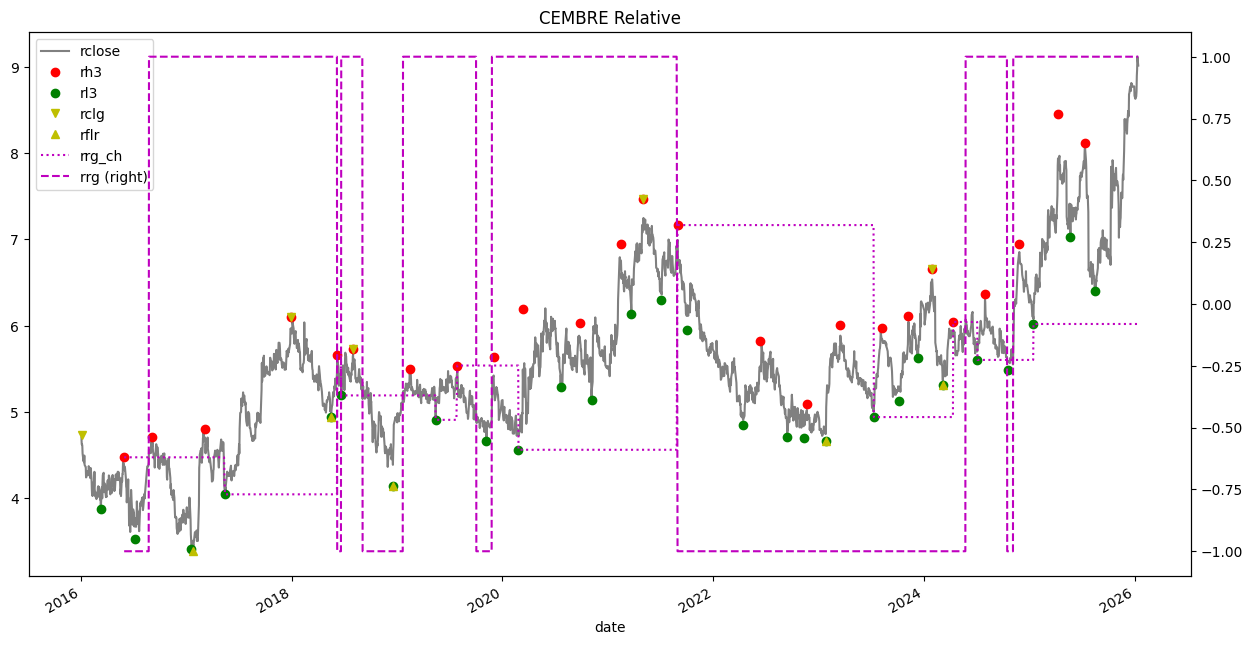

In [119]:
import matplotlib.pyplot as plt

def plot_signal_rel(df, ticker):
    
    plot_rel_cols = ['rclose','rh3', 'rl3','rclg','rflr','rrg_ch','rrg']
    plot_rel_style = ['grey', 'ro', 'go', 'yv', 'y^','m:','m--']
    y2_rel = ['rrg']

    # df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    df[plot_rel_cols].plot(secondary_y=y2_rel,figsize=(15,8),
            title = str.upper(ticker)+ ' Relative',# grid=True,
            style=plot_rel_style)
    plt.show() 

plot_signal_rel(df, 'cembre')


In [128]:
top= grid_search.df
top

,date,open,high,low,close,fx,ropen,rhigh,rlow,rclose,...,entry_rsma_150200__exit_rsma_100150,entry_rsma_150200__exit_rsma_2050100,entry_rsma_100150__exit_rema_70150200,entry_rsma_100150__exit_rsma_150200,entry_rsma_100150__exit_rsma_100150,entry_rsma_100150__exit_rsma_2050100,entry_rsma_2050100__exit_rema_70150200,entry_rsma_2050100__exit_rsma_150200,entry_rsma_2050100__exit_rsma_100150,entry_rsma_2050100__exit_rsma_2050100
0,2016-01-04,4.712308,4.712308,4.632439,4.704321,1,4.7123,4.7123,4.6324,4.7043,...,0,0,0,0,0,0,0,0,0,0
1,2016-01-05,4.704321,4.724288,4.636431,4.680360,1,4.6485,4.6682,4.5814,4.6248,...,0,0,0,0,0,0,0,0,0,0
2,2016-01-06,4.664387,4.664387,4.520621,4.556562,1,4.7356,4.7356,4.5897,4.6262,...,0,0,0,0,0,0,0,0,0,0
3,2016-01-07,4.480686,4.560556,4.328934,4.488673,1,4.6016,4.6837,4.4458,4.6098,...,0,0,0,0,0,0,0,0,0,0
4,2016-01-08,4.524614,4.524614,4.328934,4.328934,1,4.7216,4.7216,4.5174,4.5174,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,2026-01-06,19.180000,19.559999,19.000000,19.219999,1,8.6918,8.8641,8.6103,8.7100,...,0,1,1,0,1,1,1,0,1,1
2543,2026-01-07,19.420000,19.760000,19.280001,19.540001,1,8.8381,8.9928,8.7744,8.8927,...,0,1,1,1,1,1,1,1,1,1
2544,2026-01-08,19.379999,19.740000,19.299999,19.740000,1,8.7981,8.9615,8.7617,8.9615,...,1,1,1,1,1,1,1,1,1,1
2545,2026-01-09,19.799999,20.150000,19.700001,20.100000,1,8.9795,9.1382,8.9341,9.1155,...,1,1,1,1,1,1,1,1,1,1


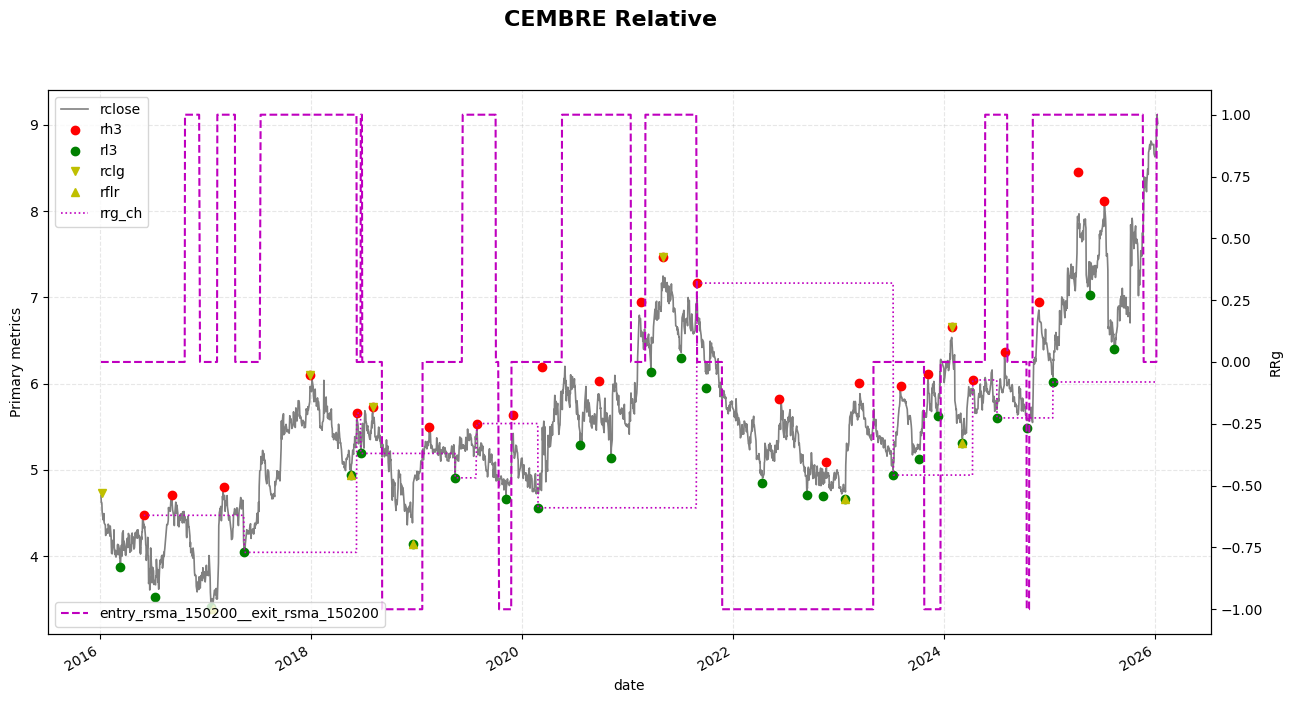

In [131]:
import matplotlib.pyplot as plt

def plot_signal_rel(df, ticker):

    plot_rel_cols = ['rclose','rh3','rl3','rclg','rflr','rrg_ch', 'entry_rsma_150200__exit_rsma_150200']
    plot_rel_style = ['grey', 'ro', 'go', 'yv', 'y^', 'm:', 'm--']
    y2_rel = ['entry_rsma_150200__exit_rsma_150200']

    df = df.set_index('date')

    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Primary axis
    df[plot_rel_cols].drop(columns=y2_rel).plot(
        ax=ax1,
        style=[s for c, s in zip(plot_rel_cols, plot_rel_style) if c not in y2_rel],
        linewidth=1.2
    )

    ax1.set_ylabel("Primary metrics")
    ax1.grid(True, linestyle="--", alpha=0.3)

    # Secondary axis
    ax2 = ax1.twinx()
    df[y2_rel].plot(
        ax=ax2,
        style=[plot_rel_style[plot_rel_cols.index(col)] for col in y2_rel],
        linewidth=1.5
    )
    ax2.set_ylabel("RRg")

    # Title
    fig.suptitle(f"{ticker.upper()} Relative", fontsize=16, fontweight="bold")

    plt.show()

plot_signal_rel(top, 'cembre')

In [3]:
optimizer = StrategyOptimizer(
    data=df,
    equity_func=get_equity,
    config_path='config.json'   # ← pass path here
)

results = optimizer.rolling_walk_forward(
    # signals='rrg',
    stop_method='atr',
    param_grid={'window': [10, 14], 'multiplier': [1.5, 2.0]},
    n_segments=4,
    opt_metric='rrg_convex'
)

2026-01-30 16:46:25,900 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:25,900 - WARNING - No peaks found, breaking loop



=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 10, 'multiplier': 1.5}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...


2026-01-30 16:46:26,720 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:26,720 - WARNING - No peaks found, breaking loop


Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 65,147.91
  rrg_concave : 84,230.38
  rrg_convex  : 81,507.82
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 10, 'multiplier': 2.0}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...


2026-01-30 16:46:27,408 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:27,408 - WARNING - No peaks found, breaking loop


Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 74,225.10
  rrg_concave : 88,027.70
  rrg_convex  : 86,047.42
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 14, 'multiplier': 1.5}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...


2026-01-30 16:46:28,164 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:28,164 - WARNING - No peaks found, breaking loop


Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 60,781.37
  rrg_concave : 83,395.58
  rrg_convex  : 80,909.96
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 14, 'multiplier': 2.0}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...
Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 71,055.88
  rrg_concave : 87,440.62
  rrg_convex  : 85,551.38
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== IS results for segment 0 ===
qui

=== Processing segment 0 |  stop_method='atr' ===
Input column

In [4]:
results[0]

,date,rrg_constant,rrg_concave,rrg_convex,rrg_equal_weight,segment_idx,start_date,end_date,signal,stop_method,stop_kwargs,rows_processed,close_col,window,multiplier,segment
0,2020-01-07,102625.60,103283.28,102894.10,96154.03,0,2017-12-29,2020-01-07,rrg,atr,"{'close_col': 'close', 'window': 10, 'multipli...",509,close,10,2.0,1
1,2022-01-04,87972.11,48229.90,93068.67,109397.24,1,2020-01-08,2022-01-04,rrg,atr,"{'close_col': 'close', 'window': 14, 'multipli...",509,close,14,1.5,2
2,2024-01-02,78726.60,60049.70,84283.70,101914.60,2,2022-01-05,2024-01-02,rrg,atr,"{'close_col': 'close', 'window': 10, 'multipli...",509,close,10,1.5,3
3,2026-01-08,58994.11,16790.39,89031.37,106340.73,3,2024-01-03,2026-01-08,rrg,atr,"{'close_col': 'close', 'window': 10, 'multipli...",509,close,10,2.0,4


In [5]:
# from algoshort.regime_bo import RegimeBO
# from algoshort.regime_ma import TripleMACrossoverRegime
# from algoshort.regime_fc import RegimeFC
# from algoshort.regime_bo import RegimeBO
# from algoshort.utils import load_config, extract_signal_name

# def multiple_fc_signals(
#         config_path: str,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     # regime_fc = RegimeFC(df=df)
#     # print(*search_space.values())
#     # for lvl_val, vlty_n_val, threshold_val, d_vol_val, dist_pct_val, retrace_pct_val, r_vol_val in zip(*search_space.values()):
#     #     # print(f"Index Match -> short: {w_val}, long: {m_val}")
#     #     df = regime_fc.compute_regime(
#     #         relative = relative,
#     #         lvl = lvl_val,
#     #         vlty_n = vlty_n_val,
#     #         threshold = threshold_val,
#     #         dgt = 3,
#     #         d_vol = d_vol_val,
#     #         dist_pct = dist_pct_val,
#     #         retrace_pct = retrace_pct_val,
#     #         r_vol = r_vol_val
#     #     )
#     config = load_config(config_path)

#     regime_fc = RegimeFC(df=df)
#     df = regime_fc.compute_regime(
#         relative = relative,
#         lvl = config['regimes']['floor_ceiling']['lvl'],
#         vlty_n = config['regimes']['floor_ceiling']['vlty_n'],
#         threshold = config['regimes']['floor_ceiling']['threshold'],
#         dgt = config['regimes']['floor_ceiling']['dgt'],
#         d_vol = config['regimes']['floor_ceiling']['d_vol'],
#         dist_pct = config['regimes']['floor_ceiling']['dist_pct'],
#         retrace_pct = config['regimes']['floor_ceiling']['retrace_pct'],
#         r_vol = config['regimes']['floor_ceiling']['r_vol']
#     )
        
#     return df

# def multiple_tt_signals(
#         search_space : dict,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     regime_bo = RegimeBO(ohlc_stock=df)

#     for w_val, m_val in zip(*search_space.values()):
#         print(f"Index Match -> short: {w_val}, long: {m_val}")
#         df = regime_bo.compute_regime(regime_type='turtle', fast_window=w_val,
#                                 window=m_val,
#                                 relative=relative, inplace=True)
        
#     return df

# def multiple_bo_signals(
#         search_space,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     regime_bo = RegimeBO(ohlc_stock=df)

#     for w_val in search_space:
#         print(f"Index Match -> Window: {w_val}")
#         df = regime_bo.compute_regime(regime_type='breakout', window=w_val,
#                              relative=relative, inplace=True)
        
#     return df

# def multiple_ma_signals(
#         search_space,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     regime_ma = TripleMACrossoverRegime(ohlc_stock=df)

#     for ma_type in ['sma', 'ema']:
#         for s_val, m_val, l_val in zip(*search_space.values()):
#             print(f"Index Match -> short: {s_val}, medium: {m_val}, long: {l_val}")
#             regime_ma.compute_ma_regime(
#                 ma_type=ma_type,
#                 short_window=s_val,
#                 medium_window=m_val,
#                 long_window=l_val,
#                 relative=relative,
#                 inplace=True
#             )    
        
#     return df

# def generate_signals(
#         df: pd.DataFrame, 
#         tt_search_space: dict,
#         bo_search_space: dict,
#         ma_search_space:dict,
#         # fc_search_space:dict,
#         config_path='./config.json',
#         relative: bool = True,
#         ) -> tuple[pd.DataFrame, list]:
#     """
#     Generates signals for breakout, Turtle Trader, and MA crossover regimes.
    
#     Args:
#         df: DataFrame with OHLC data (e.g., AAPL_Open, SPY_Close).
#         symbol: Ticker symbol (e.g., 'AAPL').
#         benchmark: Benchmark ticker (e.g., 'SPY').
#         config_path: Path to JSON config file.
    
#     Returns:
#         tuple: (DataFrame with signal columns, list of signal column names).
    
#     Raises:
#         ValueError: If input DataFrame is missing required columns or config is invalid.
#     """
#     # regime_bo = RegimeBO(ohlc_stock=df)
#     # regime_ma = TripleMACrossoverRegime(ohlc_stock=df)

#     # config = load_config(config_path)

#     df = multiple_bo_signals(search_space=bo_search_space, df=df, relative=relative)
    
#     df = multiple_tt_signals(search_space=tt_search_space, df=df, relative=relative)

#     df = multiple_ma_signals(search_space=ma_search_space,df=df,relative=relative)

#     df = multiple_fc_signals(config_path,df,relative)
    
#     # Get signal column names
#     signal_names = extract_signal_name(config_path)
    
#     # Verify signal columns exist
#     missing_signals = [name for name in signal_names if name not in df.columns]
#     if missing_signals:
#         warnings.warn(f"Signal columns not generated: {missing_signals}", UserWarning)
    
#     # Select signal columns dynamically
#     signal_columns = [col for col in df.columns if any(col.startswith(prefix) for prefix in ['rbo_', 'bo_', 'rtt_', 'tt_', 'rsma_', 'sma_', 'rema_', 'ema_', 'rg', 'rrg'])]
    
#     signal_columns = [
#         item for item in signal_columns
#         if not any(keyword in item for keyword in ['short', 'medium', 'long'])
#     ]

#     return df, signal_columns

In [6]:
# tt_search_space = {
#     'fast': [10, 20, 30],
#     'slow': [50, 50, 70]
# }

# bo_search_space = [50, 100, 150]

# ma_search_space = {
#     'short_ma': [20, 50, 70],
#     'medium_ma': [50, 100, 150],
#     'long_ma': [100, 150, 200]
# }


# df, signal_columns = generate_signals(
#     df=df,
#     tt_search_space=tt_search_space,
#     bo_search_space=bo_search_space,
#     ma_search_space=ma_search_space,
# )
# df.columns

In [7]:
# from algoshort.optimizer import get_equity

# df = get_equity(
#     segment_df=df,
#     signal='rrg',
#     segment_idx=0,
#     config_path='config.json',
#     param_grid={'window': [10], 'multiplier': [1.5]}
# )

In [8]:
# df.columns

In [9]:
# sl_signal_columns = [col for col in df.columns if any(col.endswith(prefix) for prefix in ['stop_loss'])]
# sl_signal_columns

In [10]:
# df.to_excel('check.xlsx')